# Model Evaluation
This notebook is for visualizations for evaluating model performance

## Import Libraries

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

## Load Data

In [76]:
clinician_actions = pd.read_csv('results/actual_actions.csv')
agent_actions = pd.read_csv('results/predictions.csv')
actions_map = pd.read_csv('results/ECMO_data_actions_discrete_4_hour.csv')

# only gather unique actions
actions_map.drop_duplicates(inplace=True)

## Plot Data for Each Patient

In [103]:
def plot_patient_actions(agent, clinician, action_mapping, action_type='fio2'):
    labels_map = {'fio2': ['<40', '40-49', '50-59', '>=60'],
                  'peep': ['<7', '7-8', '9-10', '11-12', '>13'],
                  'vent_rate_set': ['<15', '15-17', '18-20', '>=21']
                  }
    labels = labels_map[action_type]
    plot_title_map = {'fio2': 'FiO2',
                      'peep': 'PEEP',
                      'vent_rate_set': 'Ventilator Rate'
                      }
    plot_title = plot_title_map[action_type]
    action_cols = [x for x in action_mapping.columns.tolist() if action_type in x]
    plot_path = f'results/patient_plots/{action_type}/action_trajectory'
    os.makedirs(plot_path, exist_ok=True)
    fig, ax = plt.subplots(figsize=(20,5))

    # get per patient action predictions
    for i, csn in enumerate(agent['csn'].unique()):
        agent_preds = agent.loc[agent['csn'] == csn, 'action_number']
        agent_action_vals = []
        for action in agent_preds:
            agent_mapped_action = action_mapping.loc[action_mapping['action_number'] == action, action_cols].values.squeeze()
            agent_action_val = np.argwhere(agent_mapped_action == 1).squeeze()
            agent_action_vals.append(agent_action_val)

        clinician_preds = clinician.loc[clinician['csn'] == csn, 'action_number']
        clinician_action_vals = []
        for action in clinician_preds:
            clinician_mapped_action = action_mapping.loc[action_mapping['action_number'] == action, action_cols].values.squeeze()
            clinician_action_val = np.argwhere(clinician_mapped_action == 1).squeeze()
            clinician_action_vals.append(clinician_action_val)

        ax.plot(agent_action_vals, c='b', label='Double Q-Learning Agent')
        ax.plot(clinician_action_vals, c='r', label='Clinician')
        ax.set_xlabel('Hours')
        ax.set_ylabel(f'Setting')
        ax.set_title(plot_title)
        ax.legend()
        plt.xticks(range(43), [x*4 for x in range(43)])
        plt.yticks(range(len(labels)), labels)
        fig.savefig(f'{plot_path}/{int(csn)}.png')
        ax.clear()

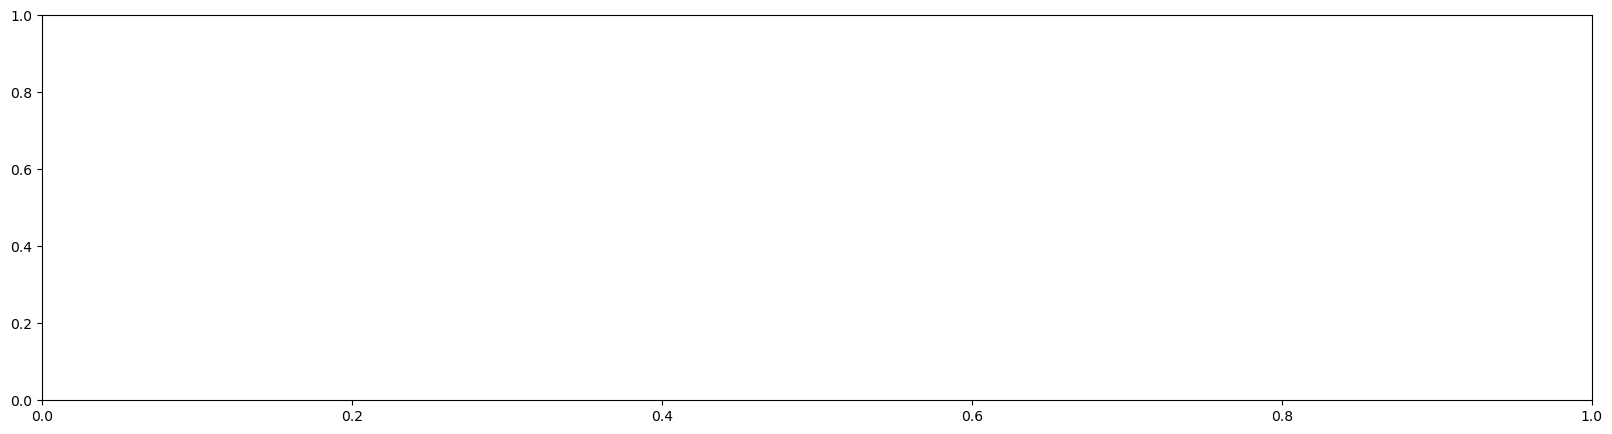

In [104]:
plot_patient_actions(agent_actions, clinician_actions, actions_map, action_type='fio2')

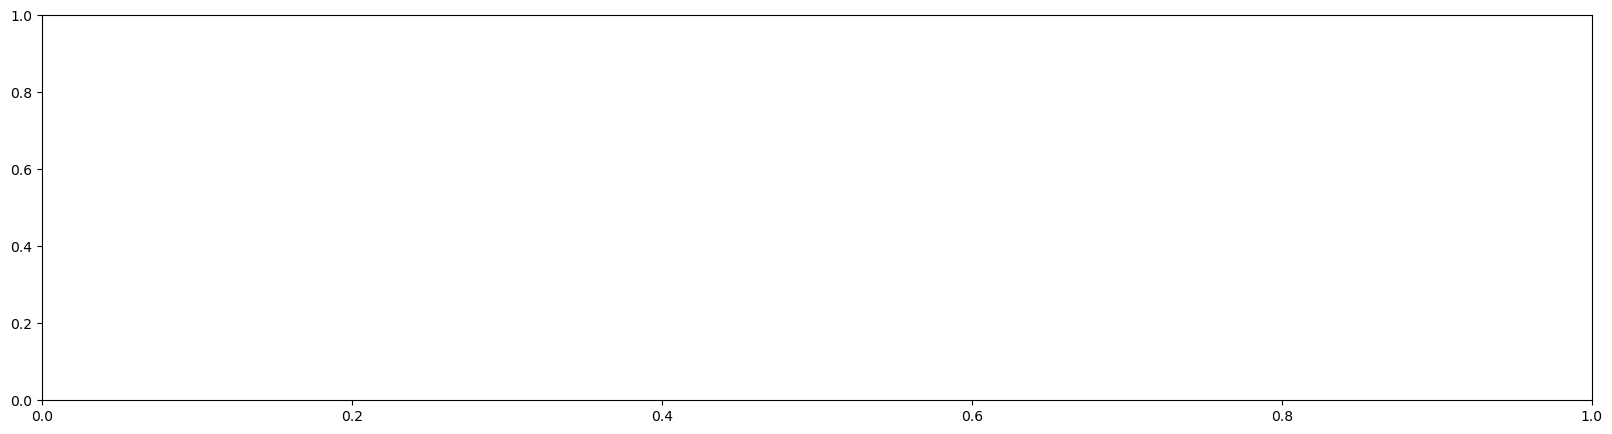

In [105]:
plot_patient_actions(agent_actions, clinician_actions, actions_map, action_type='peep')

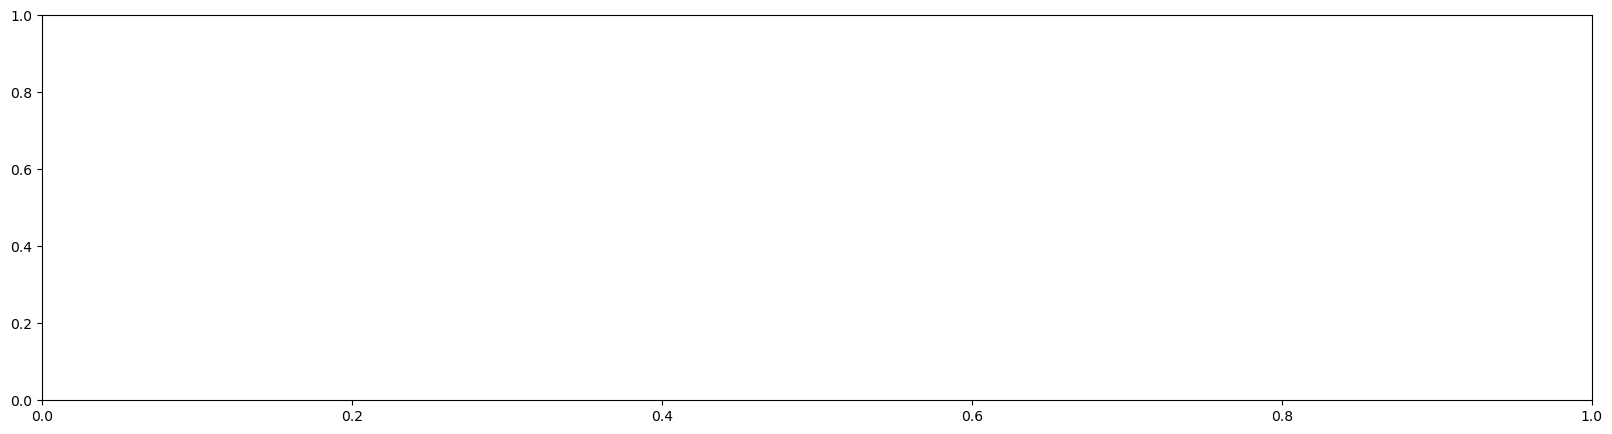

In [106]:
plot_patient_actions(agent_actions, clinician_actions, actions_map, action_type='vent_rate_set')

## Plot Global Action Changes for Each Patient

In [107]:
def plot_patient_action_changes(agent, clinician, action_mapping, action_type='fio2'):
    plot_title_map = {'fio2': 'FiO2',
                      'peep': 'PEEP',
                      'vent_rate_set': 'Ventilator Rate'
                      }
    plot_title = plot_title_map[action_type]
    action_cols = [x for x in action_mapping.columns.tolist() if action_type in x]
    plot_path = f'results/patient_plots/{action_type}/action_changes'
    os.makedirs(plot_path, exist_ok=True)
    fig, ax = plt.subplots(figsize=(10,10))

    # get per patient action predictions
    for i, csn in enumerate(agent['csn'].unique()):
        agent_preds = agent.loc[agent['csn'] == csn, 'action_number']
        agent_action_changes = 0
        prev_agent_action_val = None
        for action in agent_preds:
            agent_mapped_action = action_mapping.loc[action_mapping['action_number'] == action, action_cols].values.squeeze()
            agent_action_val = np.argwhere(agent_mapped_action == 1).squeeze()
            if prev_agent_action_val is None:
                prev_agent_action_val = agent_action_val
            elif prev_agent_action_val != agent_action_val:
                agent_action_changes += 1

        clinician_preds = clinician.loc[clinician['csn'] == csn, 'action_number']
        clinician_action_changes = 0
        prev_clinician_action_val = None
        for action in clinician_preds:
            clinician_mapped_action = action_mapping.loc[action_mapping['action_number'] == action, action_cols].values.squeeze()
            clinician_action_val = np.argwhere(clinician_mapped_action == 1).squeeze()
            if prev_clinician_action_val is None:
                prev_clinician_action_val = clinician_action_val
            elif prev_clinician_action_val != clinician_action_val:
                clinician_action_changes += 1

        counts = [agent_action_changes, clinician_action_changes]
        labels = ['Double Q-Learning Agent', 'Clinician']
        bar_colors = ['tab:blue', 'tab:red']
        ax.bar(labels, counts, color=bar_colors)
        ax.set_ylabel('Action Changes')
        ax.set_title(plot_title)
        fig.savefig(f'{plot_path}/{int(csn)}.png')
        ax.clear()

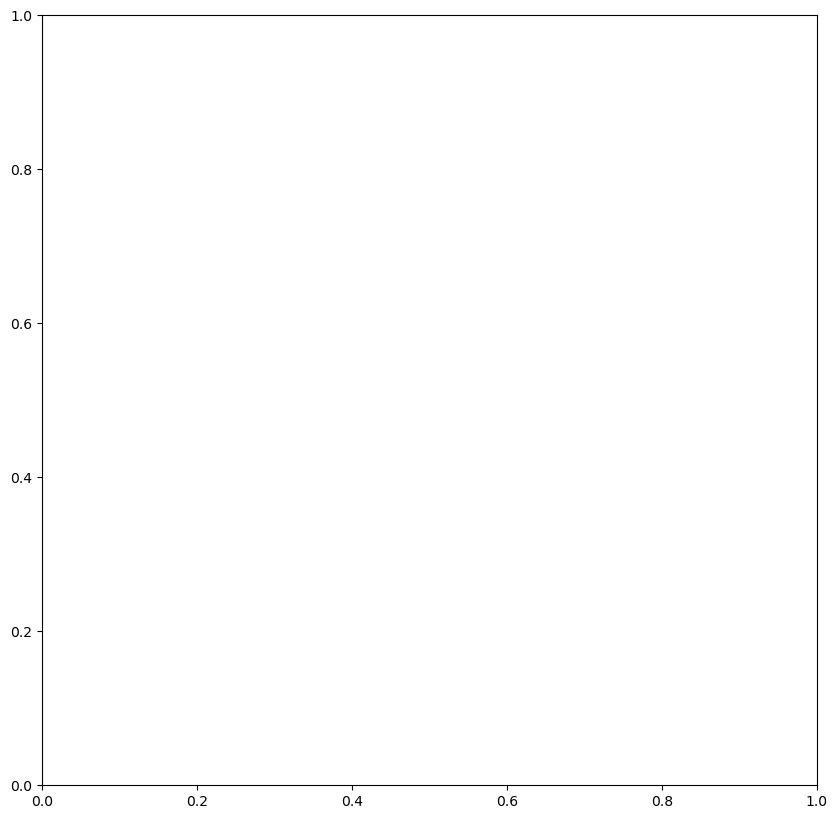

In [108]:
plot_patient_action_changes(agent_actions, clinician_actions, actions_map, action_type='fio2')

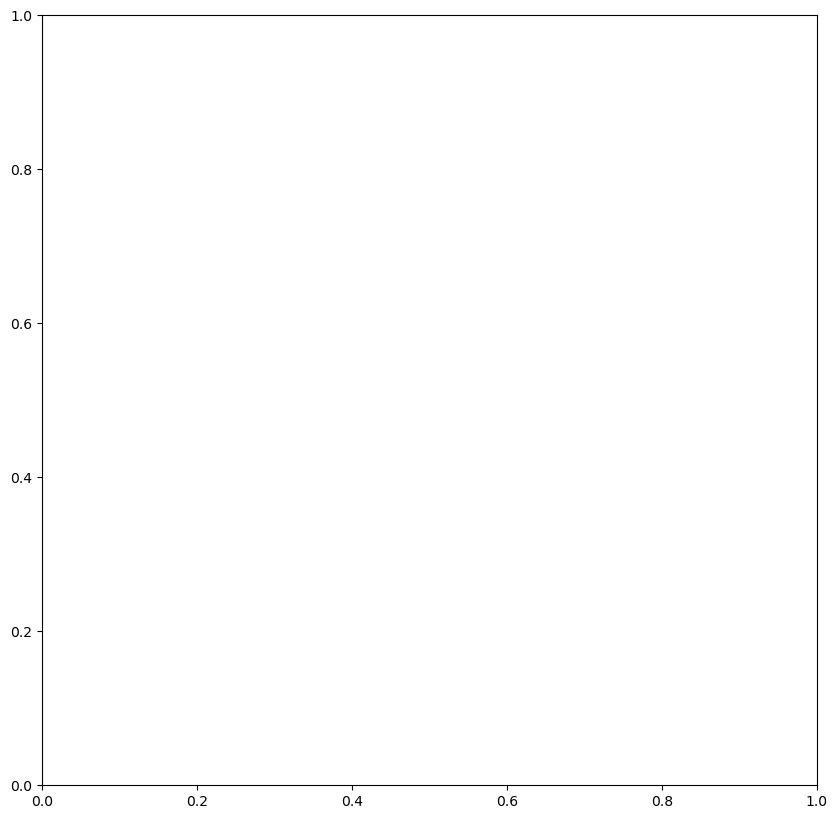

In [109]:
plot_patient_action_changes(agent_actions, clinician_actions, actions_map, action_type='peep')

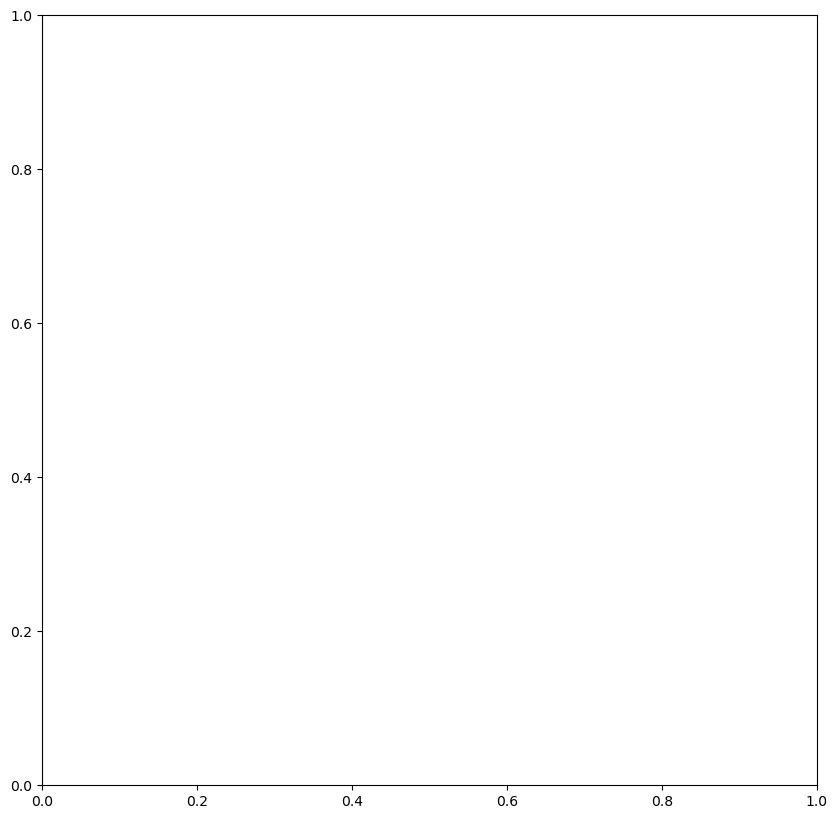

In [110]:
plot_patient_action_changes(agent_actions, clinician_actions, actions_map, action_type='vent_rate_set')